In [1]:
# https://scikit-learn.org/stable/modules/linear_model.html
# https://scikit-learn.org/stable/auto_examples/applications/plot_tomography_l1_reconstruction.html
# Author: Emmanuelle Gouillart <emmanuelle.gouillart@nsup.org>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage, sparse

from sklearn.linear_model import Lasso, Ridge

In [ ]:
def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))
# 👉 Calcula índices vecinos y pesos de interpolación lineal.
# Sirve para repartir la contribución de un píxel entre dos celdas contiguas.

def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.0
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y
# 👉 Genera las coordenadas X, Y de una grilla cuadrada de tamaño l_x × l_x, centradas en el medio.
# Esto es clave para luego poder rotar la imagen alrededor del centro.

def build_projection_operator(l_x, n_dir):
    """Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x**2)
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator
# 👉 Construye la matriz de proyección de tomografía:
# Cada fila = un rayo en cierto ángulo.
# Cada columna = un píxel de la imagen original.
# La matriz dice cómo contribuye cada píxel a cada rayo.
# Esto es la base de la Transformada de Radón en tomografía.

def generate_synthetic_data():
    """Synthetic binary data"""
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.0) ** 2 + (y - l / 2.0) ** 2 < (l / 2.0) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))
# 👉 Genera un phantom sintético (imagen binaria con formas aleatorias dentro de un círculo).
# Esto sirve como objeto de prueba para simular tomografía.

In [ ]:
# 📌 1. Definimos el tamaño de la imagen (lado del cuadrado)
l = 128  # Imagen de 128x128 píxeles

# 📌 2. Construimos el operador de proyección
# build_projection_operator(l, l//7)
# - l = 128 → imagen de 128x128
# - l//7 = 18 → número de ángulos de proyección
proj_operator = build_projection_operator(l, l // 7)

# 📌 3. Generamos datos sintéticos binarios
# generate_synthetic_data() crea una imagen de prueba de tamaño lxl
data = generate_synthetic_data()

# 📌 4. Proyectamos la imagen en distintos ángulos
# data.ravel() aplana la imagen 128x128 a un vector de 16384 elementos
# [:, np.newaxis] lo convierte en vector columna (16384,1)
# @ aplica el operador de proyección → obtenemos las "mediciones" (sinogramas)
proj = proj_operator @ data.ravel()[:, np.newaxis]

# 📌 5. Agregamos ruido gaussiano
# np.random.randn genera valores normales (media=0, var=1)
# Se multiplica por 0.15 para controlar el nivel de ruido
proj += 0.15 * np.random.randn(*proj.shape)


In [ ]:
# 📌 1. Definimos el modelo de regresión Ridge
# Ridge = regresión lineal con regularización L2
# alpha controla la penalización: mayor alpha → más suavizado
rgr_ridge = Ridge(alpha=0.2)

# 📌 2. Entrenamos el modelo
# - proj_operator: la matriz de proyección (forma ~ [n_proyecciones, n_pixeles])
# - proj.ravel(): los valores medidos (sinograma aplanado)
# El modelo intenta encontrar los coeficientes (la "imagen") que mejor explican las proyecciones.
rgr_ridge.fit(proj_operator, proj.ravel())

# 📌 3. Recuperamos la imagen reconstruida
# coef_ son los pesos asignados a cada píxel
# reshape(l, l) → volvemos a armar la imagen 2D de 128x128
rec_l2 = rgr_ridge.coef_.reshape(l, l)


In [5]:
# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)


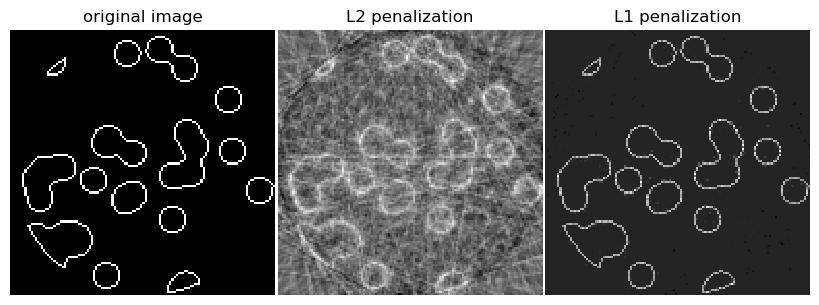

In [6]:
plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation="nearest")
plt.axis("off")
plt.title("original image")
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L2 penalization")
plt.axis("off")
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L1 penalization")
plt.axis("off")

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

plt.show()